In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%%time
drive.mount('/content/gdrive')
delay = pd.read_csv('/content/gdrive/My Drive/tmp/flights.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


<string>:2: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 13.4 s, sys: 4.4 s, total: 17.8 s
Wall time: 36.4 s


In [ ]:
delay['ori_count'] = 1
ori_count = delay.groupby(by='ORIGIN_AIRPORT').count()
ori_delay = delay[delay['DEPARTURE_DELAY']>0].groupby(by='ORIGIN_AIRPORT').count()
des_count = delay.groupby(by='DESTINATION_AIRPORT').count()
des_delay = delay[delay['ARRIVAL_DELAY']>0].groupby(by='DESTINATION_AIRPORT').count()

ori_count = pd.DataFrame(ori_count['ori_count']) # 機場出發數
ori_delay = pd.DataFrame(ori_delay['DEPARTURE_DELAY']) # 機場出發delay
des_count = pd.DataFrame(des_count['ori_count']) # 機場到達數
des_delay = pd.DataFrame(des_delay['ARRIVAL_DELAY']) # 機場到達delay

ori_count.reset_index(inplace=True)
ori_delay.reset_index(inplace=True)
des_count.reset_index(inplace=True)
des_delay.reset_index(inplace=True)

ori_count.rename(columns={'ORIGIN_AIRPORT':'airport'}, inplace=True)
ori_delay.rename(columns={'ORIGIN_AIRPORT' :'airport'}, inplace=True)
des_count.rename(columns={'DESTINATION_AIRPORT':'airport'}, inplace=True)
des_delay.rename(columns={'DESTINATION_AIRPORT':'airport'}, inplace=True)

busy = pd.merge(ori_count, ori_delay, how='outer', on='airport')
busy = pd.merge(busy, des_count, how='outer', on='airport')
busy = pd.merge(busy, des_delay, how='outer', on='airport')

### 處理機場
把origin airport 變成他的緯度

In [ ]:
airports = pd.read_csv('/content/gdrive/My Drive/tmp/airports.csv')
airports.drop(['AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LONGITUDE'], axis=1, inplace=True)
airport_dict = dict()
for index, row in airports.iterrows():
  airport_dict['%s' %row['IATA_CODE']] = row['LATITUDE']
delay['ORIGIN_AIRPORT'] = delay['ORIGIN_AIRPORT'].map(airport_dict)

### 填補NA、把出發到達時間變成數字

In [ ]:
delay.drop(['YEAR', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'DESTINATION_AIRPORT'],axis=1, inplace=True)

In [ ]:
delay['DEPARTURE_TIME'].fillna(value=delay['DEPARTURE_TIME'].mean(), inplace=True)
delay['TAXI_OUT'].fillna(value=delay['TAXI_OUT'].mean(), inplace=True)
delay['ELAPSED_TIME'].fillna(value=delay['ELAPSED_TIME'].mean(), inplace=True)
delay['DISTANCE'].fillna(value=delay['DISTANCE'].mean(), inplace=True)
delay['SCHEDULED_TIME'].fillna(value=delay['SCHEDULED_TIME'].mean(), inplace=True)

In [ ]:
delay = delay[delay.CANCELLED != 1]

In [ ]:
# 把一天的時間切成四群 0,1,2,3
delay['SCHEDULED_DEPARTURE'] = delay['SCHEDULED_DEPARTURE'].map(lambda x: x // 600)
delay['SCHEDULED_ARRIVAL'] = delay['SCHEDULED_ARRIVAL'].map(lambda x: x // 600)

In [ ]:
delay.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ori_count
0,1,1,4,AS,61.17432,0,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,0,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,1,4,AA,33.94254,0,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,1,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1,1,4,US,37.61900,0,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,1,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,1,4,AA,33.94254,0,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,1,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1,1,4,AS,47.44898,0,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,0,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1


### 處理AIRLINE變數

In [ ]:
air_delay_slow = delay[delay['DEPARTURE_DELAY']>0].groupby(by='AIRLINE').count()
air_delay_fast = delay[delay['DEPARTURE_DELAY']<0].groupby(by='AIRLINE').count()

air_delay_slow = air_delay_slow['ori_count']
air_delay_fast = air_delay_fast['ori_count']

In [ ]:
air_slow = dict()
for i in air_delay_slow.index:
  air_slow['%s' %i] = air_delay_slow[i]

air_fast = dict()
for i in air_delay_fast.index:
  air_fast['%s' %i] = air_delay_fast[i]
  
air_fast

{'AA': 435876,
 'AS': 121224,
 'B6': 147141,
 'DL': 522546,
 'EV': 365452,
 'F9': 52138,
 'HA': 52831,
 'MQ': 171352,
 'NK': 58641,
 'OO': 380084,
 'UA': 224792,
 'US': 122973,
 'VX': 34121,
 'WN': 587700}

In [ ]:
delay['AIR_SLOW'] = delay['AIRLINE'].map(air_slow)
delay['AIR_FAST'] = delay['AIRLINE'].map(air_fast)

In [ ]:
# air_count = delay['AIRLINE'].value_counts()

In [ ]:
#air_dict = dict()
#for i in air_count.index:
#  air_dict['%s' %i] = air_count[i] / air_count.sum()
  
#air_dict

In [ ]:
# delay['AIRLINE'] = delay['AIRLINE'].map(air_dict)

In [ ]:
# delay = pd.get_dummies(delay, columns=['AIRLINE'])

In [ ]:
delay.drop(['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY'
            , 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIR_TIME'
            , 'TAXI_IN', 'ARRIVAL_TIME', 'WHEELS_OFF','CANCELLED'
           , 'DIVERTED', 'WHEELS_ON', 'DEPARTURE_DELAY','CANCELLATION_REASON'
           ,'ori_count'], axis=1, inplace=True)

In [ ]:
delay.head()
#delay.info()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SLOW,AIR_FAST
0,1,1,4,AS,61.17432,0,2354.0,21.0,205.0,194.0,1448,0,-22.0,43541,121224
1,1,1,4,AA,33.94254,0,2.0,12.0,280.0,279.0,2330,1,-9.0,245550,435876
2,1,1,4,US,37.61900,0,18.0,16.0,286.0,293.0,2296,1,5.0,62452,122973
3,1,1,4,AA,33.94254,0,15.0,15.0,285.0,281.0,2342,1,-9.0,245550,435876
4,1,1,4,AS,47.44898,0,24.0,11.0,235.0,215.0,1448,0,-21.0,43541,121224


In [ ]:
delay.dropna(inplace=True)
delay.isna().sum()

MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
SCHEDULED_TIME         0
ELAPSED_TIME           0
DISTANCE               0
SCHEDULED_ARRIVAL      0
ARRIVAL_DELAY          0
AIR_SLOW               0
AIR_FAST               0
dtype: int64

將資料以航空公司分群

In [ ]:
#...
airlines = delay.groupby('AIRLINE')
airlines.size()

AIRLINE
AA     636554
AS     157025
B6     240304
DL     792941
EV     508958
F9      81861
HA      69815
MQ     257130
NK     104781
OO     528328
UA     462086
US     194223
VX      55813
WN    1136750
dtype: int64

In [ ]:
airline_AA = airlines.get_group('AA').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_AS = airlines.get_group('AS').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_B6 = airlines.get_group('B6').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_DL = airlines.get_group('DL').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_EV = airlines.get_group('EV').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_F9 = airlines.get_group('F9').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_HA = airlines.get_group('HA').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_MQ = airlines.get_group('MQ').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_NK = airlines.get_group('NK').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_OO = airlines.get_group('OO').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_UA = airlines.get_group('UA').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_US = airlines.get_group('US').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_VX = airlines.get_group('VX').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)
airline_WN = airlines.get_group('WN').drop(['AIRLINE'], axis=1).sample(n = 50000, random_state=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing
from sklearn import linear_model, metrics, model_selection

AA AS B6 DL EV F9 HA MQ NK OO UA US VX WN

In [ ]:
y_AA = pd.DataFrame()
y_AA['ARRIVAL_DELAY'] = airline_AA['ARRIVAL_DELAY']
airline_AA.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_AS = pd.DataFrame()
y_AS['ARRIVAL_DELAY'] = airline_AS['ARRIVAL_DELAY']
airline_AS.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_B6 = pd.DataFrame()
y_B6['ARRIVAL_DELAY'] = airline_B6['ARRIVAL_DELAY']
airline_B6.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_DL = pd.DataFrame()
y_DL['ARRIVAL_DELAY'] = airline_DL['ARRIVAL_DELAY']
airline_DL.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_EV = pd.DataFrame()
y_EV['ARRIVAL_DELAY'] = airline_EV['ARRIVAL_DELAY']
airline_EV.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_F9 = pd.DataFrame()
y_F9['ARRIVAL_DELAY'] = airline_F9['ARRIVAL_DELAY']
airline_F9.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_HA = pd.DataFrame()
y_HA['ARRIVAL_DELAY'] = airline_HA['ARRIVAL_DELAY']
airline_HA.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_MQ = pd.DataFrame()
y_MQ['ARRIVAL_DELAY'] = airline_MQ['ARRIVAL_DELAY']
airline_MQ.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_NK = pd.DataFrame()
y_NK['ARRIVAL_DELAY'] = airline_NK['ARRIVAL_DELAY']
airline_NK.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_OO = pd.DataFrame()
y_OO['ARRIVAL_DELAY'] = airline_OO['ARRIVAL_DELAY']
airline_OO.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_UA = pd.DataFrame()
y_UA['ARRIVAL_DELAY'] = airline_UA['ARRIVAL_DELAY']
airline_UA.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_US = pd.DataFrame()
y_US['ARRIVAL_DELAY'] = airline_US['ARRIVAL_DELAY']
airline_US.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_VX = pd.DataFrame()
y_VX['ARRIVAL_DELAY'] = airline_VX['ARRIVAL_DELAY']
airline_VX.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

y_WN = pd.DataFrame()
y_WN['ARRIVAL_DELAY'] = airline_WN['ARRIVAL_DELAY']
airline_WN.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

In [ ]:
x_train_AA, x_test_AA, y_train_AA, y_test_AA = train_test_split(airline_AA, y_AA, test_size = 0.5, random_state = 1)
x_train_AS, x_test_AS, y_train_AS, y_test_AS = train_test_split(airline_AS, y_AS, test_size = 0.5, random_state = 1)
x_train_B6, x_test_B6, y_train_B6, y_test_B6 = train_test_split(airline_B6, y_B6, test_size = 0.5, random_state = 1)
x_train_DL, x_test_DL, y_train_DL, y_test_DL = train_test_split(airline_DL, y_DL, test_size = 0.5, random_state = 1)
x_train_EV, x_test_EV, y_train_EV, y_test_EV = train_test_split(airline_EV, y_EV, test_size = 0.5, random_state = 1)
x_train_F9, x_test_F9, y_train_F9, y_test_F9 = train_test_split(airline_F9, y_F9, test_size = 0.5, random_state = 1)
x_train_HA, x_test_HA, y_train_HA, y_test_HA = train_test_split(airline_HA, y_HA, test_size = 0.5, random_state = 1)
x_train_MQ, x_test_MQ, y_train_MQ, y_test_MQ = train_test_split(airline_MQ, y_MQ, test_size = 0.5, random_state = 1)
x_train_NK, x_test_NK, y_train_NK, y_test_NK = train_test_split(airline_NK, y_NK, test_size = 0.5, random_state = 1)
x_train_OO, x_test_OO, y_train_OO, y_test_OO = train_test_split(airline_OO, y_OO, test_size = 0.5, random_state = 1)
x_train_UA, x_test_UA, y_train_UA, y_test_UA = train_test_split(airline_UA, y_UA, test_size = 0.5, random_state = 1)
x_train_US, x_test_US, y_train_US, y_test_US = train_test_split(airline_US, y_US, test_size = 0.5, random_state = 1)
x_train_VX, x_test_VX, y_train_VX, y_test_VX = train_test_split(airline_VX, y_VX, test_size = 0.5, random_state = 1)
x_train_WN, x_test_WN, y_train_WN, y_test_WN = train_test_split(airline_WN, y_WN, test_size = 0.5, random_state = 1)
print('Length of Training Set:', len(x_train_AA))
print('Length of Testing Set:', len(x_test_AA))

Length of Training Set: 25000
Length of Testing Set: 25000


In [ ]:
scaler = preprocessing.StandardScaler()

scaler.fit(x_train_AA)
x_train_AA_std = scaler.transform(x_train_AA)
x_test_AA_std = scaler.transform(x_test_AA)

scaler.fit(x_train_AS)
x_train_AS_std = scaler.transform(x_train_AS)
x_test_AS_std = scaler.transform(x_test_AS)

scaler.fit(x_train_B6)
x_train_B6_std = scaler.transform(x_train_B6)
x_test_B6_std = scaler.transform(x_test_B6)

scaler.fit(x_train_DL)
x_train_DL_std = scaler.transform(x_train_DL)
x_test_DL_std = scaler.transform(x_test_DL)

scaler.fit(x_train_EV)
x_train_EV_std = scaler.transform(x_train_EV)
x_test_EV_std = scaler.transform(x_test_EV)

scaler.fit(x_train_F9)
x_train_F9_std = scaler.transform(x_train_F9)
x_test_F9_std = scaler.transform(x_test_F9)

scaler.fit(x_train_HA)
x_train_HA_std = scaler.transform(x_train_HA)
x_test_HA_std = scaler.transform(x_test_HA)

scaler.fit(x_train_MQ)
x_train_MQ_std = scaler.transform(x_train_MQ)
x_test_MQ_std = scaler.transform(x_test_MQ)

scaler.fit(x_train_NK)
x_train_NK_std = scaler.transform(x_train_NK)
x_test_NK_std = scaler.transform(x_test_NK)

scaler.fit(x_train_OO)
x_train_OO_std = scaler.transform(x_train_OO)
x_test_OO_std = scaler.transform(x_test_OO)

scaler.fit(x_train_UA)
x_train_UA_std = scaler.transform(x_train_UA)
x_test_UA_std = scaler.transform(x_test_UA)

scaler.fit(x_train_US)
x_train_US_std = scaler.transform(x_train_US)
x_test_US_std = scaler.transform(x_test_US)

scaler.fit(x_train_VX)
x_train_VX_std = scaler.transform(x_train_VX)
x_test_VX_std = scaler.transform(x_test_VX)

scaler.fit(x_train_WN)
x_train_WN_std = scaler.transform(x_train_WN)
x_test_WN_std = scaler.transform(x_test_WN)

In [ ]:
#...flatten y
y_train_AA = (np.array(y_train_AA)).ravel()
y_test_AA = (np.array(y_test_AA)).ravel()

y_train_AS = (np.array(y_train_AS)).ravel()
y_test_AS = (np.array(y_test_AS)).ravel()

y_train_B6 = (np.array(y_train_B6)).ravel()
y_test_B6 = (np.array(y_test_B6)).ravel()

y_train_DL = (np.array(y_train_DL)).ravel()
y_test_DL = (np.array(y_test_DL)).ravel()

y_train_EV = (np.array(y_train_EV)).ravel()
y_test_EV = (np.array(y_test_EV)).ravel()

y_train_F9 = (np.array(y_train_F9)).ravel()
y_test_F9 = (np.array(y_test_F9)).ravel()

y_train_HA = (np.array(y_train_HA)).ravel()
y_test_HA = (np.array(y_test_HA)).ravel()

y_train_MQ = (np.array(y_train_MQ)).ravel()
y_test_MQ = (np.array(y_test_MQ)).ravel()

y_train_NK = (np.array(y_train_NK)).ravel()
y_test_NK = (np.array(y_test_NK)).ravel()

y_train_OO = (np.array(y_train_OO)).ravel()
y_test_OO = (np.array(y_test_OO)).ravel()

y_train_UA = (np.array(y_train_UA)).ravel()
y_test_UA = (np.array(y_test_UA)).ravel()

y_train_US = (np.array(y_train_US)).ravel()
y_test_US = (np.array(y_test_US)).ravel()

y_train_VX = (np.array(y_train_VX)).ravel()
y_test_VX = (np.array(y_test_VX)).ravel()

y_train_WN = (np.array(y_train_WN)).ravel()
y_test_WN = (np.array(y_test_WN)).ravel()

training and testing

In [ ]:
num_var = airline_AA.shape[1] # number of variables
len_data = len(y_test_AA)   # length of the data

def model_criteria(y_test, y_pred):
  k = num_var
  n = len_data
  RSS = np.sum(np.square(y_test - y_pred))
  hat_sigma_squared = RSS / (n - k - 1)
  r2 = metrics.r2_score(y_test, y_pred)
  
  MSE = metrics.mean_squared_error(y_test, y_pred)
  adj_r2= 1 - ( (1-r2) * (n-1) / (n-k-1))
  CP = (1/n) * (RSS + 2*k*hat_sigma_squared)
  AIC = (1/(n*hat_sigma_squared)) * (RSS + 2*k*hat_sigma_squared)
  BIC = (1/(n*hat_sigma_squared)) * (RSS + np.log(n) * k * hat_sigma_squared)
  
  print("* MSE: \t\t %.4f" % MSE)
  print('* Adj R^2: \t %.4f' %adj_r2)
  print("* CP: \t\t %.4f" %CP)
  print("* AIC: \t\t %.4f" %AIC)
  print("* BIC: \t\t %.4f" %BIC)
  
  return MSE, adj_r2, CP, AIC, BIC


AA:
* Feature Importance:  [0.01661766 0.00776721 0.00673621 0.03300264 0.02797924 0.3929012
 0.32023202 0.04489152 0.05203413 0.02074003 0.07709815 0.
 0.        ] 



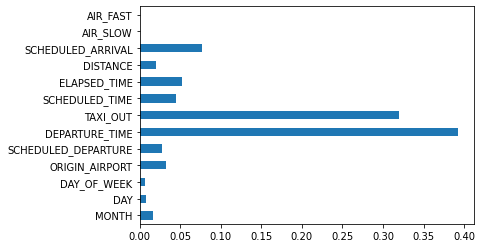

* MSE: 		 1607.1942
* Adj R^2: 	 0.1711
* CP: 		 1608.8666
* AIC: 		 1.0005
* BIC: 		 1.0047

AS:
* Feature Importance:  [0.00308106 0.00487135 0.00130502 0.0168145  0.02798926 0.24009176
 0.22057272 0.24813581 0.18029372 0.0201309  0.0367139  0.
 0.        ] 



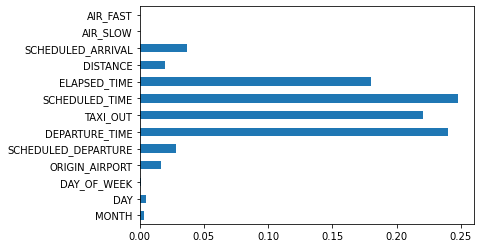

* MSE: 		 688.2429
* Adj R^2: 	 0.1856
* CP: 		 688.9591
* AIC: 		 1.0005
* BIC: 		 1.0047

B6:
* Feature Importance:  [0.01359195 0.00278918 0.00098311 0.03249382 0.03121787 0.47547043
 0.21608341 0.03386259 0.07929828 0.01773654 0.09647283 0.
 0.        ] 



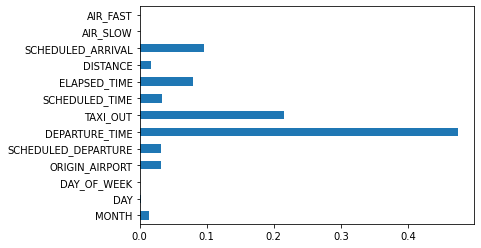

* MSE: 		 1188.1321
* Adj R^2: 	 0.3461
* CP: 		 1189.3685
* AIC: 		 1.0005
* BIC: 		 1.0047

DL:
* Feature Importance:  [0.01074237 0.0066275  0.0049373  0.03857317 0.05520746 0.39236681
 0.35225119 0.04679887 0.04229726 0.00782677 0.04237129 0.
 0.        ] 



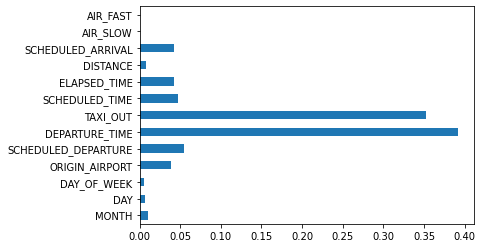

* MSE: 		 1168.7478
* Adj R^2: 	 0.1942
* CP: 		 1169.9640
* AIC: 		 1.0005
* BIC: 		 1.0047

EV:
* Feature Importance:  [0.00622204 0.00246061 0.00128916 0.01702057 0.15515858 0.47542347
 0.1843768  0.02276963 0.04165901 0.00573671 0.08788343 0.
 0.        ] 



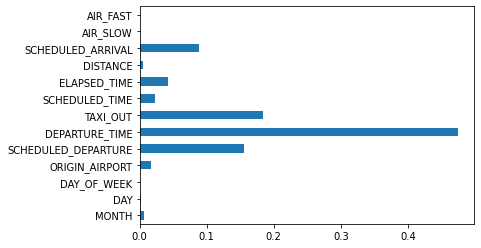

* MSE: 		 1118.3224
* Adj R^2: 	 0.3568
* CP: 		 1119.4861
* AIC: 		 1.0005
* BIC: 		 1.0047

F9:
* Feature Importance:  [0.01109456 0.00148013 0.0007498  0.00657717 0.11765364 0.59649977
 0.13551985 0.01304731 0.01604028 0.00817861 0.09315887 0.
 0.        ] 



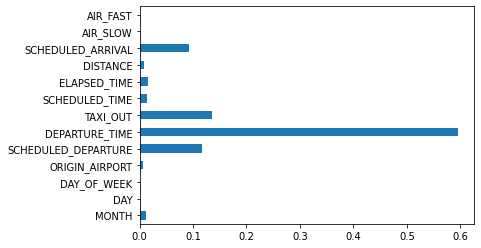

* MSE: 		 1550.7815
* Adj R^2: 	 0.4259
* CP: 		 1552.3952
* AIC: 		 1.0005
* BIC: 		 1.0047

HA:
* Feature Importance:  [0.06979337 0.02283761 0.00945876 0.03843684 0.00472889 0.17315707
 0.03994758 0.20138235 0.38651406 0.0400275  0.01371597 0.
 0.        ] 



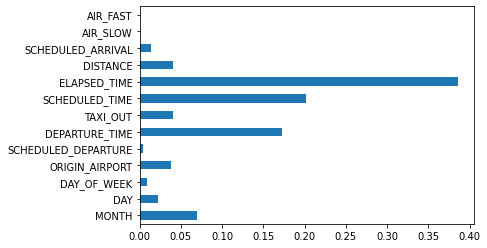

* MSE: 		 631.4884
* Adj R^2: 	 0.1195
* CP: 		 632.1455
* AIC: 		 1.0005
* BIC: 		 1.0047

MQ:
* Feature Importance:  [0.07030663 0.03630207 0.00265463 0.02908229 0.02140039 0.28695294
 0.32969925 0.04251111 0.09206207 0.02404485 0.06498376 0.
 0.        ] 



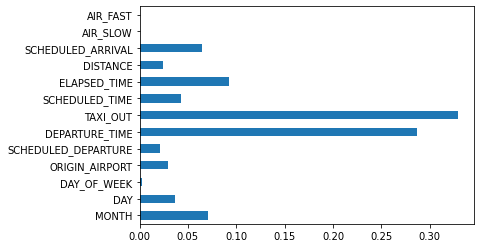

* MSE: 		 1517.1778
* Adj R^2: 	 0.2414
* CP: 		 1518.7566
* AIC: 		 1.0005
* BIC: 		 1.0047

NK:
* Feature Importance:  [3.23931812e-03 9.34092455e-04 2.09031186e-04 2.43534011e-02
 2.62767027e-01 4.43871095e-01 1.04730399e-01 1.78371501e-02
 2.90535580e-02 1.46873592e-02 9.83175689e-02 0.00000000e+00
 0.00000000e+00] 



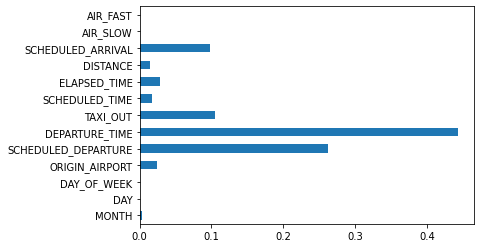

* MSE: 		 1256.4555
* Adj R^2: 	 0.4375
* CP: 		 1257.7629
* AIC: 		 1.0005
* BIC: 		 1.0047

OO:
* Feature Importance:  [0.00210856 0.00292224 0.00180837 0.01265107 0.15088254 0.49065134
 0.17305615 0.00644196 0.02643196 0.00595522 0.12709058 0.
 0.        ] 



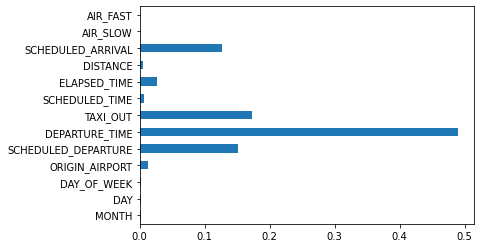

* MSE: 		 1047.2363
* Adj R^2: 	 0.3381
* CP: 		 1048.3260
* AIC: 		 1.0005
* BIC: 		 1.0047

UA:
* Feature Importance:  [0.0134839  0.00610797 0.00189705 0.01061484 0.06617183 0.49705149
 0.22592187 0.01705    0.02365867 0.01254328 0.1254991  0.
 0.        ] 



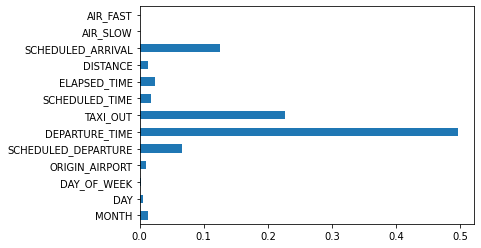

* MSE: 		 1510.6735
* Adj R^2: 	 0.2916
* CP: 		 1512.2454
* AIC: 		 1.0005
* BIC: 		 1.0047

US:
* Feature Importance:  [0.00522256 0.0045751  0.00269048 0.02218001 0.15306066 0.27905047
 0.41023055 0.02061669 0.03720686 0.00924609 0.05592052 0.
 0.        ] 



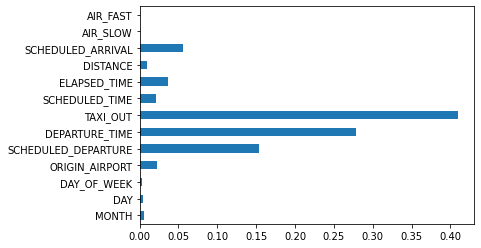

* MSE: 		 710.1126
* Adj R^2: 	 0.2862
* CP: 		 710.8516
* AIC: 		 1.0005
* BIC: 		 1.0047

VX:
* Feature Importance:  [0.00672653 0.00466884 0.00463067 0.03126379 0.15590829 0.40131542
 0.15940723 0.08849931 0.10129085 0.01189937 0.03438971 0.
 0.        ] 



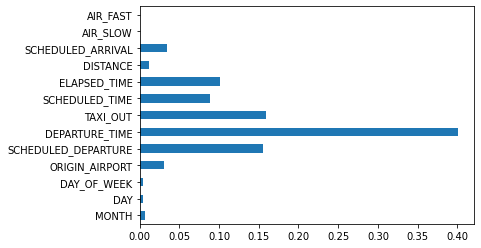

* MSE: 		 773.1349
* Adj R^2: 	 0.3865
* CP: 		 773.9394
* AIC: 		 1.0005
* BIC: 		 1.0047

WN:
* Feature Importance:  [0.01247531 0.00471728 0.00545398 0.01006041 0.02885779 0.69745637
 0.12771126 0.02747085 0.04391774 0.00968119 0.03219782 0.
 0.        ] 



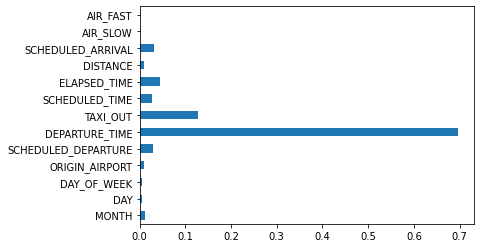

* MSE: 		 776.4279
* Adj R^2: 	 0.2685
* CP: 		 777.2358
* AIC: 		 1.0005
* BIC: 		 1.0047
CPU times: user 54.3 s, sys: 85.3 ms, total: 54.4 s
Wall time: 54.4 s


In [ ]:
%%time
airline_list = ['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN']
x_train_list = [x_train_AA_std, x_train_AS_std, x_train_B6_std, x_train_DL_std, x_train_EV_std, x_train_F9_std, x_train_HA_std, x_train_MQ_std, x_train_NK_std, x_train_OO_std, x_train_UA_std, x_train_US_std, x_train_VX_std, x_train_WN_std]
y_train_list = [y_train_AA, y_train_AS, y_train_B6, y_train_DL, y_train_EV, y_train_F9, y_train_HA, y_train_MQ, y_train_NK, y_train_OO, y_train_UA, y_train_US, y_train_VX, y_train_WN]
x_test_list = [x_test_AA_std, x_test_AS_std, x_test_B6_std, x_test_DL_std, x_test_EV_std, x_test_F9_std, x_test_HA_std, x_test_MQ_std, x_test_NK_std, x_test_OO_std, x_test_UA_std, x_test_US_std, x_test_VX_std, x_test_WN_std]
y_test_list = [y_test_AA, y_test_AS, y_test_B6, y_test_DL, y_test_EV, y_test_F9, y_test_HA, y_test_MQ, y_test_NK, y_test_OO, y_test_UA, y_test_US, y_test_VX, y_test_WN]

for i in range(len(x_train_list)):
  forest = ensemble.RandomForestRegressor(n_estimators=50, min_samples_split=2, min_samples_leaf=100)
  forest.fit(x_train_list[i], y_train_list[i])

  y_pred = forest.predict(x_test_list[i])
  print('\n' + airline_list[i] + ':')
  print("* Feature Importance: ", forest.feature_importances_, "\n")
  feat_importances = pd.Series(forest.feature_importances_, index=airline_AA.columns)
  feat_importances.plot(kind='barh')
  plt.show()

  model_criteria(y_test_list[i], y_pred)

  

### 挑選出小全部機場緯度10%的機場
冬天可能會被暴雪所影響，所以這邊挑選出較低緯地區，<br/>
等同於創造一個0.1的sample

In [ ]:
print("Length of Origin Data:", len(delay))

In [ ]:
# 找出後面0.1的緯度
delay['ORIGIN_AIRPORT'].quantile([0.1])

In [ ]:
delay = delay[delay['ORIGIN_AIRPORT'] <= 29.53369]

In [ ]:
print("Length of Data:", len(delay))
# 這樣就不用抽樣了

## 初步將處理好後，開始分割train / test 套model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing
from sklearn import linear_model, metrics, model_selection

### 抽樣

In [ ]:
# delay_sam = delay.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
y = pd.DataFrame()
y['ARRIVAL_DELAY'] = delay['ARRIVAL_DELAY']

delay.drop(['ARRIVAL_DELAY'], axis = 1, inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(delay, y, test_size = 0.1, random_state = 1)
print('Length of Training Set:', len(x_train))
print('Length of Testing Set:', len(x_test))

### 資料標準化



In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.ravel()
y_test = y_test.ravel()

---
### 爻 煞氣a模型標準產生器 爻


In [ ]:
num_var = delay.shape[1] # number of variables
len_data = len(y_test)   # length of the data

def model_criteria(y_test, y_pred):
  k = num_var
  n = len_data
  RSS = np.sum(np.square(y_test - y_pred))
  hat_sigma_squared = RSS / (n - k - 1)
  r2 = metrics.r2_score(y_test, y_pred)
  
  MSE = metrics.mean_squared_error(y_test, y_pred)
  adj_r2= 1 - ( (1-r2) * (n-1) / (n-k-1))
  CP = (1/n) * (RSS + 2*k*hat_sigma_squared)
  AIC = (1/(n*hat_sigma_squared)) * (RSS + 2*k*hat_sigma_squared)
  BIC = (1/(n*hat_sigma_squared)) * (RSS + np.log(n) * k * hat_sigma_squared)
  
  print("* MSE: \t\t %.4f" % MSE)
  print('* Adj R^2: \t %.4f' %adj_r2)
  print("* CP: \t\t %.4f" %CP)
  print("* AIC: \t\t %.4f" %AIC)
  print("* BIC: \t\t %.4f" %BIC)
  
  return MSE, adj_r2, CP, AIC, BIC

In [ ]:
# import xgboost as xgb
# from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
# from sklearn.linear_model import Ridge,Lasso,LinearRegression
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import cross_val_score
# scores = []
# var = []
# #using model
# lin = LinearRegression()
# rlin = Ridge()
# lasso = Lasso()
# rf = RandomForestRegressor(n_estimators=100,min_samples_leaf=50)
# gb = GradientBoostingRegressor()
# xgbr = xgb.XGBRegressor()
# model=[lin,rlin,lasso,rf,gb,xgbr]
# model_name=['LinearRegression','Ridge','Lasso','RandomForest','GradientBoosting','XGBRegressor']

# def selfdefine_score(y_test, y_pred):
#     return metrics.mean_squared_error(y_test, y_pred)
# my_score = make_scorer(selfdefine_score,greater_is_better = False)

# for m in model:
#     score = -cross_val_score(m, x_train, y_train, cv=5, scoring=my_score)
#     scores.append(score.mean())
#     var.append(score.std())
#     print(score)
#     score = []
# #視覺化資料
# plt.figure(figsize = (16,12))
# plt.bar(model_name, scores)  
# plt.xlabel('model')  
# plt.ylabel('Cross-Validated for MSE')  
# plt.show()
# plt.figure(figsize = (16,12))
# plt.bar(model_name, var)
# plt.xlabel('model')  
# plt.ylabel('MSE_std.') 
# plt.show()

### Linear Regression

In [ ]:
%%time

lm = linear_model.LinearRegression()
lm.fit(x_train_std, y_train)
y_pred = lm.predict(x_test_std)

print('* Intercept: \n', lm.intercept_ )
print('* Coefficients: \n', lm.coef_, "\n")
# model_criteria(y_test, y_pred)
model_criteria(y_test, y_pred)

### Ridge Regression

使用預設

In [ ]:
%%time

reg = linear_model.Ridge()
reg.fit(x_train_std, y_train)
y_pred = reg.predict(x_test_std)

print('* Intercept: \n', reg.intercept_ )
print('* Coefficients: \n', reg.coef_, "\n")

model_criteria(y_test, y_pred)

---
使用交叉驗證挑選train的最佳alpha：

In [ ]:
%%time

alpha_list = np.linspace(start=0, stop=5, num=20)

reg = linear_model.RidgeCV(alphas=alpha_list, cv=10)
reg.fit(x_train_std, y_train)

print('Best Alpha:', reg.alpha_ )

把test放進用train fit的模型：

In [ ]:
%%time

y_pred = reg.predict(x_test_std)

print('* Intercept: \n', reg.intercept_ )
print('* Coefficients: \n', reg.coef_, "\n")

model_criteria(y_test, y_pred)

### Lasso

In [ ]:
%%time

EPSILON = 1e-4
lassocv = linear_model.LassoCV(cv=10, tol=0.01, max_iter=1500)
lassocv.fit(x_train_std, y_train)

m_log_alphas = -np.log10(lassocv.alphas_ + EPSILON)
plt.figure()

plt.plot(m_log_alphas, lassocv.mse_path_, ':')
plt.plot(m_log_alphas, lassocv.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lassocv.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent')
plt.axis('tight')

best_alpha = lassocv.alpha_
print('Best Alpha:', lassocv.alpha_ )

In [ ]:
# model_bic = linear_model.LassoLarsIC(criterion='bic')
# model_bic.fit(x_train_std, y_train)
# alpha_bic_ = model_bic.alpha_

# model_aic = linear_model.LassoLarsIC(criterion='aic')
# model_aic.fit(x_train_std, y_train)
# alpha_aic_ = model_aic.alpha_

# def plot_ic_criterion(model, name, color):
#     alpha_ = model.alpha_ + EPSILON
#     alphas_ = model.alphas_ + EPSILON
#     criterion_ = model.criterion_
#     plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
#              linewidth=3, label='%s criterion' % name)
#     plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
#                 label='alpha: %s estimate' % name)
#     plt.xlabel('-log(alpha)')
#     plt.ylabel('criterion')

# plt.figure()
# plot_ic_criterion(model_aic, 'AIC', 'b')
# plot_ic_criterion(model_bic, 'BIC', 'r')
# plt.legend()
# plt.title('Information-criterion for model selection')

# print('Alpha BIC: ', alpha_bic_)
# print('Alpha AIC: ', alpha_aic_)

In [ ]:
%%time
# lasso = linear_model.Lasso(alpha=best_alpha)
# lasso.fit(x_train_std, y_train)

y_pred = lassocv.predict(x_test_std)

print('* Intercept: \n', lassocv.intercept_ )
print('* Coefficients: \n', lassocv.coef_)

model_criteria(y_test, y_pred)

### 把係數縮為0的拿掉：

In [ ]:
# count=0
# zero_list = []
# for i in lasso.coef_:
#     if i == 0:
#         zero_list.append(count)
#     count += 1

# print(x_train.columns[[zero_list]])

In [ ]:
# x_train_sub = x_train
# x_train_sub = x_train_sub.drop(x_train_sub.columns[[zero_list]], axis=1)
# x_test_sub = x_test
# x_test_sub = x_test_sub.drop(x_test_sub.columns[[zero_list]], axis=1)
# x_train_sub.head(3)

### 再跑一次Linear Regression

In [ ]:
# %%time

# lm = linear_model.LinearRegression()
# lm.fit(x_train_sub, y_train)
# y_pred = lm.predict(x_test_sub)

# print('* Intercept: \n', lm.intercept_ )
# print('* Coefficients: \n', lm.coef_)

# print("* MSE: %.3f"
#       % metrics.mean_squared_error(y_test, y_pred))

# print('* R Square: %.3f' % metrics.r2_score(y_test, y_pred))

### Random Forest Regressor

In [ ]:
%%time

forest = ensemble.RandomForestRegressor(n_estimators=50, min_samples_split=2, min_samples_leaf=100)
forest.fit(x_train_std, y_train)

y_pred = forest.predict(x_test_std)

print("* Feature Importance: ", forest.feature_importances_, "\n")

model_criteria(y_test, y_pred)

In [ ]:
forest.get_params()

In [ ]:
from sklearn.externals import joblib

In [ ]:
# save the model
joblib.dump(forest, '/content/gdrive/Team Drives/Machine Learning/flight-delays/forest.pkl')

In [ ]:
# load the model
forest = joblib.load('/content/gdrive/Team Drives/Machine Learning/flight-delays/forest.pkl')

In [ ]:
forest.fit(x_train_std, y_train)

y_pred = forest.predict(x_test_std)

print("* Feature Importance: ", forest.feature_importances_, "\n")

model_criteria(y_test, y_pred)

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
%%time
xgbr = xgb.XGBRegressor()
xgbr.fit(x_train_std, y_train)
y_pred = xgbr.predict(x_test_std)

model_criteria(y_test, y_pred)

In [ ]:
xgb.plot_importance(xgbr, max_num_features=20, height=0.5)

### SVR

In [ ]:
from sklearn.svm import SVR

In [ ]:
%%time

svr = SVR()
svr.fit(x_train_std, y_train)
y_pred = svr.predict(x_test_std)

model_criteria(y_test, y_pred)

### PCA

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pca = PCA(n_components=3)

x_train_pca = pca.fit_transform(x_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
plt.scatter(x_train_pca[:,0], x_train_pca[:,1], x_train_pca[:,2], alpha=0.2)

In [ ]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train)
print("Explained Variance Ratio: ", pca.explained_variance_ratio_)
print("Singular Values: ", pca.singular_values_)
print(x_train_pca.shape)
plt.scatter(x_train_pca[:,0], x_train_pca[:,1], alpha=0.2)

In [ ]:
%%time

pca = PCA(n_components=5)

x_train_pca = pca.fit_transform(x_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

### PCA (N=1~12)

In [ ]:
%%time
pca_result = []

for i in range(1, 13):
  pca = PCA(n_components=i)
  x_train_pca = pca.fit_transform(x_train)
  print("N =", i)
  print("\n")
  print(pca.explained_variance_ratio_)
  
  x_test_pca = pca.transform(x_test)
  
  lm = linear_model.LinearRegression()
  lm.fit(x_train_pca, y_train)
  y_pred = lm.predict(x_test_pca)

  print('* Intercept: \n', lm.intercept_ )
  print('* Coefficients: \n', lm.coef_, "\n")

  num_var =  i# number of variables
  len_data = len(y_test)   # length of the data
  temp = model_criteria(y_test, y_pred)
  pca_result.append(temp)
  
  print("====================\n")

In [ ]:
result_df = pd.DataFrame(pca_result, columns=['MSE', 'ADJ_R2', 'CP', 'AIC', 'BIC'])

In [ ]:
result_df

In [ ]:
plt.plot(result_df['MSE'], marker='o')
plt.plot(result_df['CP'], marker='o')

plt.show()

In [ ]:
plt.plot(result_df['AIC'], marker='o')
plt.plot(result_df['BIC'], marker='o')

plt.show()

In [ ]:
plt.plot(result_df['ADJ_R2'], marker='o')

In [ ]:
x_test_pca = pca.transform(x_test)

In [ ]:
%%time

lm = linear_model.LinearRegression()
lm.fit(x_train_pca, y_train)
y_pred = lm.predict(x_test_pca)

print('* Intercept: \n', lm.intercept_ )
print('* Coefficients: \n', lm.coef_, "\n")

num_var = 2 # number of variables
len_data = len(y_test)   # length of the data
model_criteria(y_test, y_pred)

### 修改參數

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time

param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch1.fit(x_train_std, y_train)
y_pred = xgbr.predict(x_test_std)


print('* R Square: %.3f' % metrics.r2_score(y_test, y_pred))

print("* MSE: %.3f"
      % metrics.mean_squared_error(y_test, y_pred))

### 儲存模型

In [ ]:
from sklearn.externals import joblib

In [ ]:
# save the model
joblib.dump(xgbr, '/content/gdrive/Team Drives/Machine Learning/flight-delays/xgbr.pkl')

In [ ]:
# load the model
xgbr = joblib.load('/content/gdrive/Team Drives/Machine Learning/flight-delays/xgbr.pkl')